In [1]:
# Standard stuff
import numpy as np

# Energy-flow package for CMS Open Data loader
import energyflow as ef
from energyflow.archs import PFN, EFN
from energyflow.utils import remap_pids

In [40]:
def load_data(cache_dir, pt_lower, pt_upper, eta, quality, pad, x_dim = 3, momentum_scale = 250, n = 100000, amount = 1, max_particle_select = None, frac = 1.0, return_pfcs = True):

    # Load data
    specs = [f'{pt_lower} <= gen_jet_pts <= {pt_upper}', f'abs_gen_jet_eta < {eta}', f'quality >= {quality}']
    # specs = [f'{pt_lower} <= jet_pts <= {pt_upper}', f'abs_jet_eta < {eta}', f'quality >= {quality}']
    sim = ef.mod.load(*specs, cache_dir = cache_dir, dataset='sim', amount= amount, store_gens = False)

    # Gen_pt for Y
    Y1 = sim.jets_f[:,sim.gen_jet_pt]
    Y = np.zeros((Y1.shape[0], 1), dtype = np.float32 )
    Y[:,0] = Y1 / momentum_scale

    # Sim_pt for X
    X = np.zeros((Y1.shape[0],3), dtype = np.float32)
    event_ids = np.zeros((Y1.shape[0],1), dtype = np.int32)
    X[:,0] = sim.jets_f[:,sim.jet_pt] / momentum_scale
    X[:,1] = sim.jets_f[:,sim.jet_eta]
    X[:,2] = sim.jets_f[:,sim.jet_phi]
    event_ids = sim.jets_i[:,sim.evn]



    # CMS JEC's
    C = sim.jets_f[:,sim.jec]

    # PFC's
    pfcs = sim.particles


    pfcs = pfcs[:n]
    Y = Y[:n]
    X = X[:n]
    C = C[:n]
    event_ids = event_ids[:n]

    # PFC's
    dataset = np.zeros( (pfcs.shape[0], pad, x_dim), dtype = np.float32 )
    particle_counts = []
    if return_pfcs:
        for (i, jet) in enumerate(pfcs):
            size = min(jet.shape[0], pad)
            indices = (-jet[:,0]).argsort()
            dataset[i, :size, 0] = jet[indices[:size],0] / momentum_scale
            dataset[i, :size, 1] = jet[indices[:size],1]
            dataset[i, :size, 2] = jet[indices[:size],2]
            if x_dim == 4:
                dataset[i, :size, 3] = jet[indices[:size],4] # PID
            particle_counts.append(jet.shape[0])
        if x_dim == 4:
            remap_pids(dataset, pid_i = 3, error_on_unknown = False)

        for x in dataset:
            mask = x[:,0] > 0
            yphi_avg = np.average(x[mask,1:3], weights = x[mask,0], axis = 0)
            x[mask,1:3] -= yphi_avg  

    particle_counts = np.array(particle_counts)

    # Trim and shuffle
    if max_particle_select is not None:
        dataset = dataset[particle_counts < max_particle_select]
        Y = Y[particle_counts < max_particle_select]
        X = X[particle_counts < max_particle_select]
        C = C[particle_counts < max_particle_select]
        particle_counts = particle_counts[particle_counts < max_particle_select]


    print("X: ", X.shape, X.dtype)
    print("Y: ", Y.shape, Y.dtype)
    print("PFCs: ", dataset.shape, dataset.dtype)

    if not return_pfcs:
        return X, Y, C, particle_counts, event_ids
   
    print("Max # of particles: %d" % max(particle_counts))
    return X, dataset, Y, C, particle_counts, event_ids


In [41]:
y_dim = 1
x_dim = 3



# Dataset Parameters
cache_dir = "/n/holyscratch01/iaifi_lab/rikab/.energyflow"
momentum_scale = 1000
n = 10000
pad = 150
pt_lower, pt_upper = 500, 1000
eta = 2.4
quality = 2

# #############################
# ########## DATASET ##########
# #############################

X, Y, C, N, ids = load_data(cache_dir, pt_lower, pt_upper, eta, quality, pad, momentum_scale = momentum_scale, n = n, max_particle_select = None, amount = 1, return_pfcs= False)
X_test, Y_test, C_test, N_test, ids_test = load_data(cache_dir, pt_lower, pt_upper, eta, quality, pad, momentum_scale = momentum_scale, n = 50, return_pfcs= False)


X:  (10000, 3) float32
Y:  (10000, 1) float32
PFCs:  (10000, 150, 3) float32
X:  (50, 3) float32
Y:  (50, 1) float32
PFCs:  (50, 150, 3) float32


In [47]:
sorted = np.sort(ids)
sorted_indices = ids.argsort()
print(ids.shape)
print(sorted)


counter = 0
pairs = []
N = len(sorted)
for (i,id) in enumerate(sorted):
    for (j, id2) in enumerate(sorted[(i+1):]):

        if id == id2:
            counter += 1
            pairs.append((i, i+1+j))
            break

        if id2 > id:
            break

print(counter / N )

(10000,)
[    532     566     764 ... 5991576 5991586 5991621]
0.209


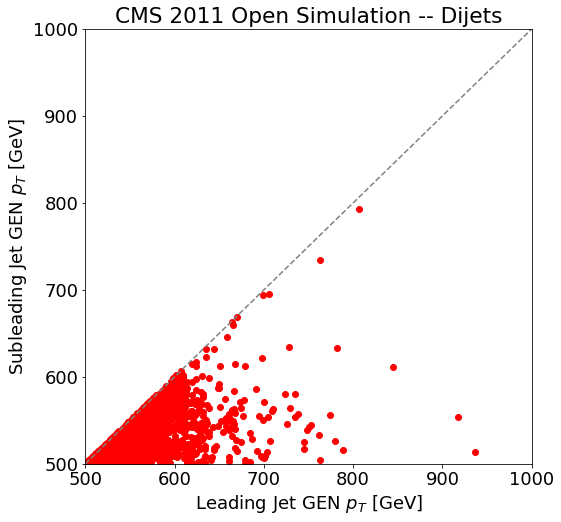

In [95]:
from matplotlib import pyplot as plt


sorted_gen_pts = Y[sorted_indices]
sorted_sim_pts = X[sorted_indices,0]

leading_gen_pts = []
subleading_gen_pts = []
leading_sim_pts = []
subleading_sim_pts = []

for pair in pairs:

    jet1 = sorted_gen_pts[pair[0]]
    jet2 = sorted_gen_pts[pair[1]]

    sim_jet1 = sorted_sim_pts[pair[0]]
    sim_jet2 = sorted_sim_pts[pair[1]]


    if jet1 > jet2:
        leading_gen_pts.append(jet1)
        subleading_gen_pts.append(jet2)
        leading_sim_pts.append(sim_jet1)
        subleading_sim_pts.append(sim_jet2)
    else:
        leading_gen_pts.append(jet2)
        subleading_gen_pts.append(jet1)
        leading_sim_pts.append(sim_jet2)
        subleading_sim_pts.append(sim_jet1)

leading_gen_pts = np.array(leading_gen_pts)
subleading_gen_pts = np.array(subleading_gen_pts)

leading_sim_pts = np.array(leading_sim_pts)
subleading_sim_pts = np.array(subleading_sim_pts)

# Plot

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.rcParams['font.size'] = '18'


plt.scatter(leading_gen_pts * 1000, subleading_gen_pts * 1000, color = "red")
plt.plot(np.linspace(500, 1000, 50), np.linspace(500, 1000, 50), color = "grey", ls = "--")

plt.xlim(500,  1000)
plt.ylim(500,  1000)
plt.xlabel("Leading Jet GEN $p_T$ [GeV]")
plt.ylabel("Subleading Jet GEN $p_T$ [GeV]")
plt.title("CMS 2011 Open Simulation -- Dijets")
plt.savefig("Plots/leading_subleading.pdf")


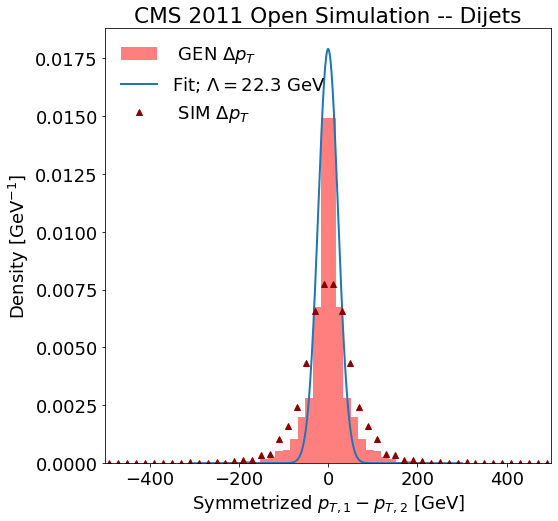

In [104]:
from scipy.stats import norm
from scipy.optimize import curve_fit

diffs = (leading_gen_pts - subleading_gen_pts)*1000
symmetrized_diffs = np.concatenate((diffs, -diffs))
# symmetrized_diffs = symmetrized_diffs[symmetrized_diffs < 200]
# symmetrized_diffs = symmetrized_diffs[symmetrized_diffs > -200]

sim_diffs = (leading_sim_pts - subleading_sim_pts)*1000
sim_symmetrized_diffs = np.concatenate((sim_diffs, -sim_diffs))


# Gaussian Fit
bins = 50
lims = (-500, 500)
hist, bin_edges = np.histogram(symmetrized_diffs, density=True, bins = bins, range = lims)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1., 0., 50.]
coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
mu, std = coeff[1], coeff[2]

x = np.linspace(-300,300, 500)
pdf = norm.pdf(x, mu, std)


# Plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.rcParams['font.size'] = '18'

plt.hist(symmetrized_diffs, bins = 50, density = True, label = " GEN $\Delta p_T$", color = "red", alpha = 0.5)
plt.plot(x, pdf, linewidth = 2, label = "Fit; $\Lambda = %.1f$ GeV" % std)

hist, bin_edges = np.histogram(sim_symmetrized_diffs, density=True, bins = bins, range = lims)
plt.plot(bin_centres, hist,  "^", color= "darkred", label = " SIM $\Delta p_T$")


plt.title("CMS 2011 Open Simulation -- Dijets")
plt.xlim(*lims)
plt.legend(frameon = False,loc = "upper left")
plt.xlabel("Symmetrized $p_{T,1} - p_{T,2}$ [GeV]")
plt.ylabel("Density [GeV$^{-1}$]")
plt.savefig("Plots/momentum_conservation.pdf")
plt.show()